# **SIOC 221A - Analysis of Physical Oceanographic Data (A) - Problem 6** 

# Caique Dias Luko 



### 1. Compute two spectra. For this problem set, please generate a 10,000 element data set with Gaussian white noise. Use your white noise to generate a second data set that is the time integral of the first. Hint: use cumsum in MATLAB; note you’ll need to specify the sample interval.) Now compute and plot spectra for the white noise and time-integrated data sets by breaking the data up into segments with 50% overlaps, with no windowing. (You can do this by reshaping your data vector as a 500×20 matrix, which will give you 20 segments, each 500 points long, and a 500×19 matrix containing the 50% overlaps.). Make sure you plot the spectrum with correct units and that you verify normalization using Parseval’s theorem.

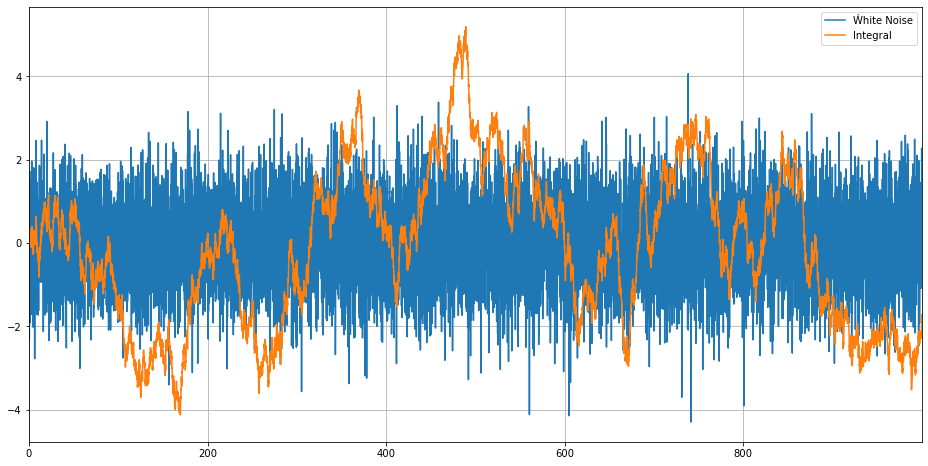

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rec1 = np.random.randn(10000)
rec2 = np.cumsum(rec1.copy())*0.1

# Let's say that the sample interval is 0.1 day
t = np.arange(10000)*0.1

plt.figure(figsize=(16,8))
plt.plot(t,rec1,label='Ẃhite Noise')
plt.plot(t,rec2,label='Integral')
plt.legend(loc='best')
plt.xlim(t[0],t[-1])
plt.grid()

In [2]:
def compspectrum(data,tday,tstep,demean=True,overlap=False,detren=False,hanning=False):
    # data is an array with the data
    # tday is the time vector in days
    # tstep should be in days

    import numpy as np
    import xarray as xr
    from scipy.signal import detrend

    # Segmenting
    if overlap == False:
        data = data.reshape(500,20)
    if overlap == True:
        x1 = data.reshape(500,20)
        x2 = data[249:-251].reshape(500,19)
        data = np.concatenate((x1,x2),axis=1)

    # Removing the mean
    if demean == True:
        data = data-np.nanmean(data,axis=0)
        
    # Computing frequencies
    freq = np.fft.fftshift(np.fft.fftfreq(data.shape[0],d=tstep))
    # Indexes of positive freqs
    idx = np.where(freq>0)[0]
    freq=freq[idx]
    
    if detren==False and hanning==False:
        ffts = np.fft.fftshift(np.fft.fft(data,axis=0,norm=None),axes=0)[idx]
    if detren==True and hanning ==False:
        ffts = np.fft.fftshift(np.fft.fft(detrend(data,axis=0),axis=0,norm=None),axes=0)[idx]
    if detren==True and hanning == True:
        hann = np.hanning(data.shape[0])
        fac = np.sqrt(np.nanmean(hann**2)) 
        hann = hann/fac # Normalizing to get <hann**2>=1
        _,Hann = np.meshgrid(data.shape[1],hann)
        ffts = np.fft.fftshift(np.fft.fft(detrend(data,axis=0)*Hann,axis=0,norm=None),axes=0)[idx]

        
    df = 1./(data.shape[0]*tstep)
    
    ffts = (abs(ffts)**2)/(data.shape[0]**2) 
    ffts = (ffts*2)/df 
    
    return np.nanmean(ffts,axis=1),freq,data.shape[1]


spec1,freq,segs = compspectrum(rec1,t,0.1,demean=True,overlap=True,detren=True,hanning=True)
spec2,freq,segs = compspectrum(rec2,t,0.1,demean=True,overlap=True,detren=True,hanning=True)


import scipy.integrate as integrate

var1 = np.nanstd(rec1)**2
pars1 = integrate.trapezoid(spec1,freq)

var2 = np.nanstd(rec2)**2
pars2 = integrate.trapezoid(spec2,freq)

print('Parseval ratio White noise: ',var1/pars1)
print('Parseval ratio Integrated white noise: ',var2/pars2)

Parseval ratio White noise:  0.9867038260653935
Parseval ratio Integrated white noise:  1.0792535360492246


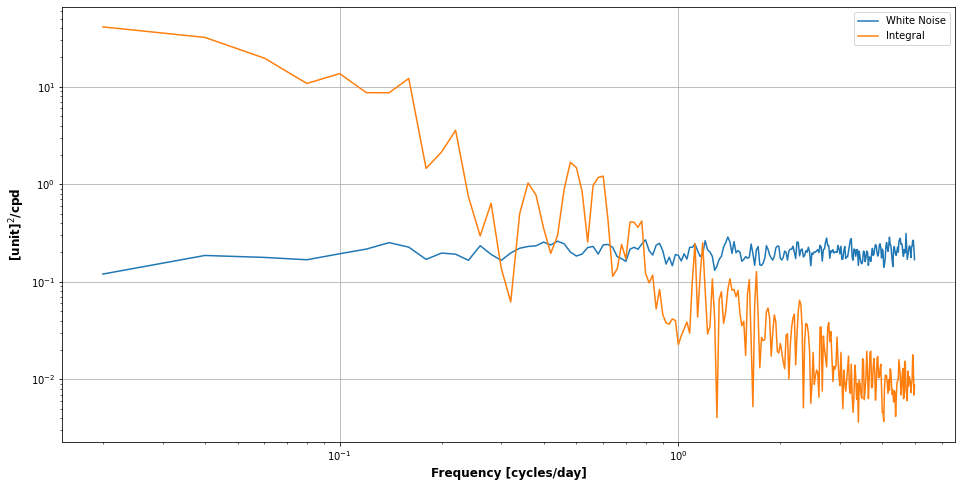

In [3]:
# Plotting spectra
plt.figure(figsize=(16,8))
plt.loglog(freq,spec1,label='White Noise')
plt.loglog(freq,spec2,label='Integral')
plt.legend(loc='best')
plt.xlabel('Frequency [cycles/day]',weight='bold',fontsize=12)
plt.ylabel('[unit]$^2$/cpd',weight='bold',fontsize=12)
plt.grid()


### 2. Analytical spectra. Given that you know the variance of your white-noise time series, overplot the expected analytical spectrum (hint: use Parseval’s theorem). Then, for the time-integrated spectrum, use the relationship we learned for Fourier coefficients of derivatives and integrals to overplot the analytical spectrum for the spectrum of the time-integral.

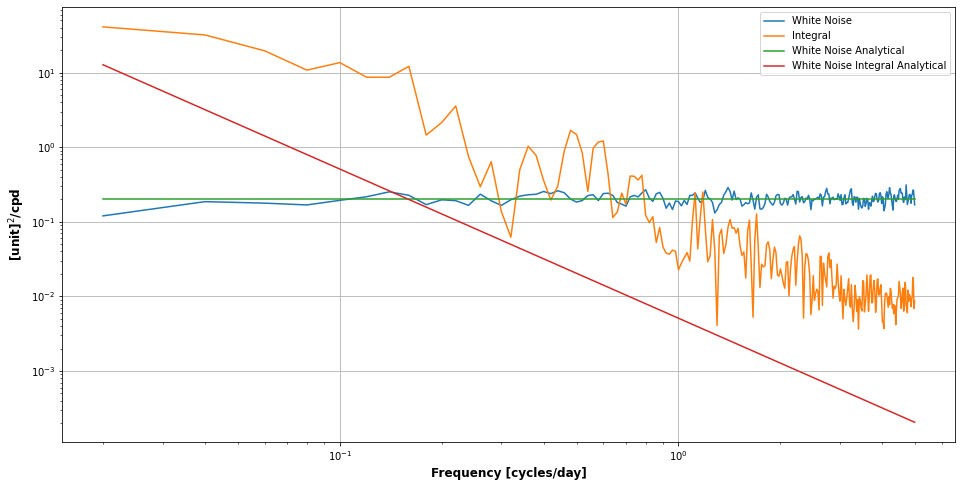

In [4]:
# Analytical noise spectrum
phi1 = np.ones(freq.shape[0])*var1/(1./(2*0.1)) 
# Analytical integral. Integral at time space is the division of the spectra by the i*2pi*f at frequency space. 
# It is squared because we are taking the squared absolute value. 
phi2 = phi1/(2*np.pi*freq)**2

plt.figure(figsize=(16,8))
plt.loglog(freq,spec1,label='White Noise')
plt.loglog(freq,spec2,label='Integral')
plt.loglog(freq,phi1,label='White Noise Analytical')
plt.loglog(freq,phi2,label='White Noise Integral Analytical')
plt.legend(loc='best')
plt.xlabel('Frequency [cycles/day]',weight='bold',fontsize=12)
plt.ylabel('[unit]$^2$/cpd',weight='bold',fontsize=12)
plt.grid()


### 3. Error bars. Following the procedure that you’ve used before, add error bars to your spectra. Justify how you computed them.

In [5]:
from scipy.stats.distributions import chi2

# For each non-overlapping segment we get 2 degrees of freedom. 
# We are overlapping, but the data just shows up twice. 
# The df is 2*number of non-overlapping segments

df= 20*2 
err_low = df/chi2.ppf(1-.05/2,df)
err_high = df/chi2.ppf(.05/2,df)

print(err_low,err_high)

0.6740621718801201 1.6371274862846865


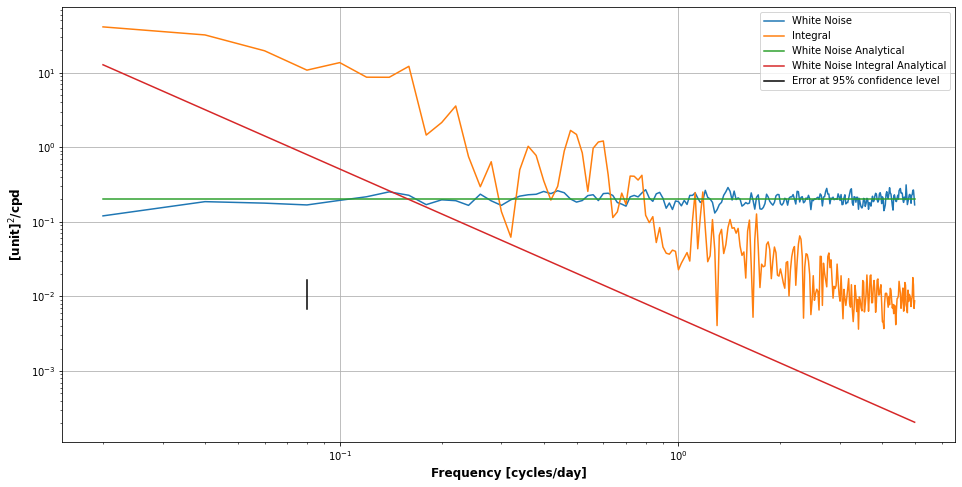

In [6]:
plt.figure(figsize=(16,8))
plt.loglog(freq,spec1,label='White Noise')
plt.loglog(freq,spec2,label='Integral')
plt.loglog(freq,phi1,label='White Noise Analytical')
plt.loglog(freq,phi2,label='White Noise Integral Analytical')
plt.semilogy([freq[3],freq[3]],np.array([err_low,err_high])*1e-2,color='black',label='Error at 95% confidence level')
plt.legend(loc='best')
plt.xlabel('Frequency [cycles/day]',weight='bold',fontsize=12)
plt.ylabel('[unit]$^2$/cpd',weight='bold',fontsize=12)
plt.grid()

### 4. Use Monte Carlo simulation to verify the χ2 error bars. To check the error bars, you’ll want to generate multiple ensembles of data and compute spectra for each of them. I suggest using 200 matrices that are 500×20 elements each. Compute spectra for each of them. This will provide you with 200 independent realizations of the spectrum, and you can use these 200 values to study the range of possible spectra that you could obtain from white noise. Examine the pdf of your 200 values. (Because the statistics of Gaussian white noise are the same at all frequencies, you can merge all the frequencies to produce a larger ensemble.) Is the pdf consistent with your expectations for a variable with a χ2 distribution?

In [7]:
Spec = np.ones((200,249))*np.nan
Freq = np.ones((200,249))*np.nan
Pars = np.ones(200)*np.nan
for n in range(200):
    rec1 = np.random.randn(10000)
    spec,freq,_ = compspectrum(rec1,t,0.1,demean=True,overlap=False,detren=True,hanning=False)
    Spec[n] = spec.copy()
    Freq[n] = freq.copy()
    Pars[n] = (np.nanstd(rec1)**2)/integrate.trapezoid(spec,freq) 
     
pdf,bins=np.histogram(Spec.ravel(),bins=100,density=True)   
bins = 0.5*(bins[0:-1]+bins[1:])

print('PDF integral: ',round(integrate.trapezoid(pdf,bins),4))

Pars

PDF integral:  1.0


array([1.00846878, 1.00872979, 1.01143407, 1.01010652, 1.01109637,
       1.00660395, 1.01092857, 1.00929648, 1.00970179, 1.00878172,
       1.01152968, 1.00964505, 1.00933715, 1.00923412, 1.00829264,
       1.00835748, 1.01061483, 1.00855352, 1.01145392, 1.00990001,
       1.00832196, 1.01124008, 1.00845465, 1.01034609, 1.01050232,
       1.00921441, 1.00878458, 1.0080988 , 1.00895763, 1.01037657,
       1.00982688, 1.01105818, 1.00897454, 1.01158349, 1.00833549,
       1.00980608, 1.00847732, 1.0077889 , 1.00927286, 1.00844631,
       1.01153368, 1.00803797, 1.00970187, 1.01029832, 1.00985133,
       1.00972022, 1.00727567, 1.00805216, 1.00817258, 1.00905975,
       1.01071171, 1.00924985, 1.00910896, 1.00934984, 1.00923688,
       1.00979706, 1.00934293, 1.00984814, 1.01159859, 1.00698883,
       1.00871694, 1.00994982, 1.0088129 , 1.00992713, 1.00957416,
       1.0094832 , 1.00863457, 1.00792278, 1.00787128, 1.00789851,
       1.00921091, 1.00918496, 1.00891436, 1.00900364, 1.01147

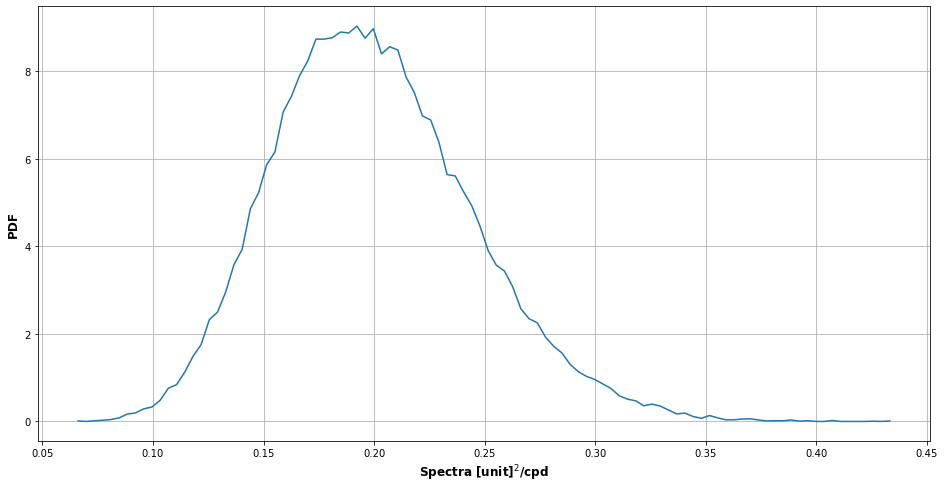

In [8]:
# PDF of all values to get a larger ensemble

fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
plt.plot(bins,pdf)
plt.xlabel('Spectra [unit]$^2$/cpd',weight='bold',fontsize=12)
plt.ylabel('PDF',weight='bold',fontsize=12)

plt.grid()


The PDF does look like a χ2 distribution. It has a skewness towards high values but still looks like a gaussian because we have a lot of degrees of freedom.

### Now, for each frequency, sort the 200 realizations of the pdf by size (e.g. using the “sort” command in Matlab. Since you are looking for the 95% confidence range, you’ll want to find the limits that exclude the lowest 2.5% and the highest 2.5% of your data—presumably the 6th and 195th points in each sorted set of pdfs.) What is the ratio of the upper limit to the lower limit? Are the error bars derived using the Monte Carlo process consistent with those from question 1?

2.4287484961785464 2.507563539147504


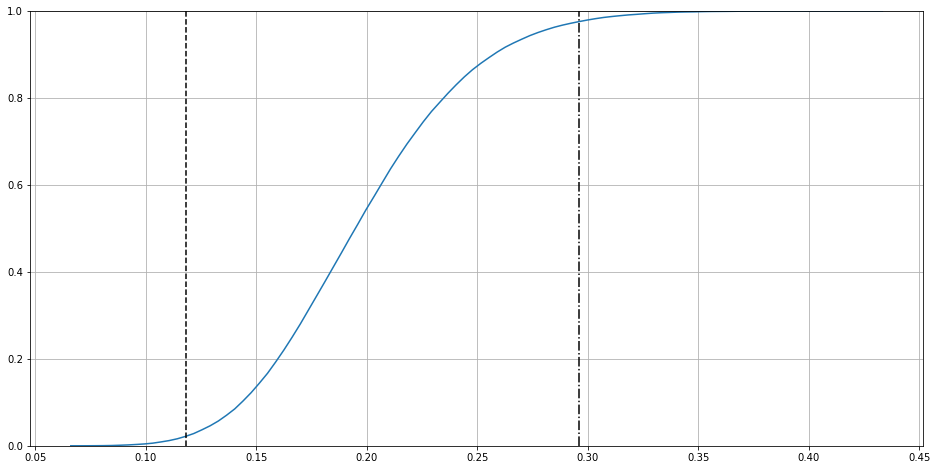

In [9]:
fig=plt.figure(figsize=(16,8))
dbin = np.diff(bins)[0]
cdf = np.cumsum(pdf*dbin)
idx1 = np.where(cdf<=0.025)[0][-1]
idx2 = np.where(cdf>=0.975)[0][0]

ax=fig.add_subplot(111)
plt.plot(bins,cdf)
plt.plot([bins[idx1],bins[idx1]],[0,1],linestyle='--',color='k')
plt.plot([bins[idx2],bins[idx2]],[0,1],linestyle='-.',color='k')
plt.ylim(0,1)
plt.grid()

In [17]:
errm_low=bins[idx1]
errm_high=bins[idx2]
print('Ratio regular approach: ',err_high/err_low,'\nRatio Montecarlo:       ',errm_high/errm_low)

print('\nErrorbars from chi-2 distribution')
print('Lower limit: ',err_low,'Upper Limit: ',err_high)

print('\nErrorbars from Montecarlo')
print('Lower limit: ',errm_low,'Upper Limit: ',errm_high)

Ratio regular approach:  2.4287484961785464 
Ratio Montecarlo:        2.507563539147504

Errorbars from chi-2 distribution
Lower limit:  0.6740621718801201 Upper Limit:  1.6371274862846865

Errorbars from Montecarlo
Lower limit:  0.11805913283324501 Upper Limit:  0.29604077695601716


### 5. Monte Carlo process for a Hanning window. Repeat the Monte Carlo process to estimate the χ 2 error bars for data using a Hanning window for each segment and 50% overlap. Are the results consistent with what you would expect based on the discussion in class?

In [25]:

Spech = np.ones((200,249))*np.nan
Freqh = np.ones((200,249))*np.nan
Parsh = np.ones(200)*np.nan
for n in range(200):
    rec1 = np.random.randn(10000)
    spec,freq,_ = compspectrum(rec1,t,0.1,demean=True,overlap=True,detren=True,hanning=True)
    Spech[n] = spec.copy()
    Freqh[n] = freq.copy()
    Parsh[n] = (np.nanstd(rec1)**2)/integrate.trapezoid(spec,freq) 
     
pdfh,binsh=np.histogram(Spech.ravel(),bins=100,density=True)   
binsh = 0.5*(binsh[0:-1]+binsh[1:])

dbinh = np.diff(binsh)[0]
cdfh = np.cumsum(pdfh*dbinh)

idx1h = np.where(cdfh<=0.025)[0][-1]
idx2h = np.where(cdfh>=0.975)[0][0]

errm_lowh=binsh[idx1h]
errm_highh=binsh[idx2h]

print('Ratio Montecarlo:        ',errm_high/errm_low,'\nRatio Montecarlo Hanning:',errm_highh/errm_lowh)

print('\nErrorbars from Montecarlo')
print('Lower limit: ',errm_low,'Upper Limit: ',errm_high)

print('\nErrorbars from Montecarlo Hanning')
print('Lower limit: ',errm_lowh,'Upper Limit: ',errm_highh)

Ratio Montecarlo:         2.507563539147504 
Ratio Montecarlo Hanning: 1.9372281390457258

Errorbars from Montecarlo
Lower limit:  0.11805913283324501 Upper Limit:  0.29604077695601716

Errorbars from Montecarlo Hanning
Lower limit:  0.1381011768740958 Upper Limit:  0.2675334858758292


The results are consistent because we observe a narrower errorbar when using the Hanning Window. The precision of the spectrum is higher.

### 6. Monte Carlo process for a cosine window. Finally, repeat the Monte Carlo process for a cosine window (cos(πt/T), where −T /2 < t < T /2). How many effective degrees of freedom do you obtain for 50% overlap.

In [29]:
def compspectrum_cosinewindow(data,tday,tstep):
    # data is an array with the data
    # tday is the time vector in days
    # tstep should be in days

    import numpy as np
    import xarray as xr
    from scipy.signal import detrend

    # Segmenting
    x1 = data.reshape(500,20)
    x2 = data[249:-251].reshape(500,19)
    data = np.concatenate((x1,x2),axis=1)

    # Removing the mean
    data = data-np.nanmean(data,axis=0)
        
    # Computing frequencies
    freq = np.fft.fftshift(np.fft.fftfreq(data.shape[0],d=tstep))
    # Indexes of positive freqs
    idx = np.where(freq>0)[0]
    freq=freq[idx]

    # Cosine window
    cos = np.cos(np.pi*np.arange(data.shape[0])*0.1/(data.shape[0]*0.1))
    fac = np.sqrt(np.nanmean(cos**2)) 
    cos = cos/fac # Normalizing to get <hann**2>=1
    _,COS = np.meshgrid(data.shape[1],cos)
    ffts = np.fft.fftshift(np.fft.fft(detrend(data,axis=0)*COS,axis=0,norm=None),axes=0)[idx]

        
    df = 1./(data.shape[0]*tstep)
    
    ffts = (abs(ffts)**2)/(data.shape[0]**2) 
    ffts = (ffts*2)/df 
    
    return np.nanmean(ffts,axis=1),freq,data.shape[1]



######################
Specc = np.ones((200,249))*np.nan
Freqc = np.ones((200,249))*np.nan
Parsc = np.ones(200)*np.nan
for n in range(200):
    rec1 = np.random.randn(10000)
    spec,freq,_ = compspectrum_cosinewindow(rec1,t,0.1)
    Specc[n] = spec.copy()
    Freqc[n] = freq.copy()
    Parsc[n] = (np.nanstd(rec1)**2)/integrate.trapezoid(spec,freq) 
     
pdfc,binsc=np.histogram(Specc.ravel(),bins=100,density=True)   
binsc = 0.5*(binsc[0:-1]+binsc[1:])

dbinc = np.diff(binsc)[0]
cdfc = np.cumsum(pdfc*dbinc)

idx1c = np.where(cdfc<=0.025)[0][-1]
idx2c = np.where(cdfc>=0.975)[0][0]

errm_lowc=binsc[idx1c]
errm_highc=binsc[idx2c]

print('Ratio Montecarlo:        ',errm_high/errm_low,'\nRatio Montecarlo Cosine:',errm_highc/errm_lowc)

print('\nErrorbars from Montecarlo')
print('Lower limit: ',errm_low,'Upper Limit: ',errm_high)

print('\nErrorbars from Montecarlo Hanning')
print('Lower limit: ',errm_lowh,'Upper Limit: ',errm_highh)

print('\nErrorbars from Montecarlo Cosine')
print('Lower limit: ',errm_lowc,'Upper Limit: ',errm_highc)

Ratio Montecarlo:         2.507563539147504 
Ratio Montecarlo Cosine: 1.9295462621901054

Errorbars from Montecarlo
Lower limit:  0.11805913283324501 Upper Limit:  0.29604077695601716

Errorbars from Montecarlo Hanning
Lower limit:  0.1381011768740958 Upper Limit:  0.2675334858758292

Errorbars from Montecarlo Cosine
Lower limit:  0.13805845149431012 Upper Limit:  0.26639016904460006
